In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import glob
import re
import random
import os
from itertools import groupby
from toy_model_helper import *
from datetime import datetime
import pytz

In [2]:
# default parameters
param = {'act_func': 'linear',
         'epoch_n': 1000,
         'save_interval': 500,
         'r1_size': 100,
         's10': 100,
         's11': 100,
         's21': 100,
         's22': 100,
         's32': 100,
         'alpha_1': 0.5,
         'alpha_2': 0.5,
         'beta_1': 10,
         'beta_2': 10,
         'beta_3': 10,
         'gamma_1': 10,
         'gamma_2': 10,
         'softmax_c': 1,
         'recog_mode': 1,
         'recog_value': 1,
         'in_dir': './data/3x3/',
         'out_dir': './results',
         'timestamp': datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d_%H-%M-%S'),
         'ipynb': 'toy_model_kalman_variant_1.ipynb',
         'param_id': None}

In [3]:
param = pd.Series(param)
param

act_func                                   linear
epoch_n                                      1000
save_interval                                 500
r1_size                                       100
s10                                           100
s11                                           100
s21                                           100
s22                                           100
s32                                           100
alpha_1                                       0.5
alpha_2                                       0.5
beta_1                                         10
beta_2                                         10
beta_3                                         10
gamma_1                                        10
gamma_2                                        10
softmax_c                                       1
recog_mode                                      1
recog_value                                     1
in_dir                                ./data/3x3/


In [4]:
for x in param.index:
    if isinstance(param[x], str):
        exec("{} = '{}'".format(x, param[x]))
    else:
        exec("{} = {}".format(x, param[x]))

In [5]:
def apply_input(I_dict, training=False, af="linear", seed=None):
    global U1_hat, U2_hat, U3_hat, V1_hat, V2_hat
    
    output = {"input": [], "label": [], "target_vec": [], "timestep": [],
              "r1_bar": [], "r2_bar": [], "r1_hat": [], "r2_hat": [],
              "U1_hat": [], "U2_hat": [], "U3_hat": [], "V1_hat": [],  "V2_hat": [], "training": []}
    
    if training == True:
        np.random.seed(seed)
        I_order = random.sample(list(I_dict.keys()), len(list(I_dict.keys())))
    elif training == False:
        I_order = list(I_dict.keys())
    
    for k in I_order:
        I = I_dict[k]
        k_idx = list(I_dict.keys()).index(k)
        L = np.eye(len(I_dict))[k_idx]
        L0 = softmax(np.zeros(len(I_dict)))

        r1_hat = r1.copy()
        r2_hat = r2.copy()

        for idx in np.arange(I.shape[1]):
            r1_hat_old = r1_hat.copy()
            r2_hat_old = r2_hat.copy()

            U1_bar = U1_hat.copy()
            U2_bar = U2_hat.copy()
            U3_bar = U3_hat.copy()

            V1_bar = V1_hat.copy()
            V2_bar = V2_hat.copy()

            r1_bar = f(V1_bar @ r1_hat_old, af=af)
            r2_bar = f(V2_bar @ r2_hat_old, af=af)

            r1_hat = r1_bar + alpha_1/s10 * U1_bar.T @ f_prime(U1_bar @ r1_bar, af=af) @ (I[:, idx] - f(U1_bar @ r1_bar, af=af)) - alpha_1/s21 * (r1_bar - f(U2_bar @ r2_bar, af=af))
            r2_hat = r2_bar + alpha_2/s21 * U2_bar.T @ f_prime(U2_bar @ r2_bar, af=af) @ (r1_bar - f(U2_bar @ r2_bar, af=af)) - alpha_2/s32 * (r2_bar - f(U3_bar @ L0, af=af))

            if training == True:
                r2_hat = r2_bar + alpha_2/s21 * U2_bar.T @ f_prime(U2_bar @ r2_bar, af=af) @ (r1_bar - f(U2_bar @ r2_bar, af=af)) - alpha_2/s32 * (r2_bar - f(U3_bar @ L, af=af))

                U1_hat = U1_bar + beta_1/s10 * f_prime(U1_bar @ r1_hat, af=af) @ np.outer(I[:, idx] - f(U1_bar @ r1_hat, af=af), r1_hat)
                U2_hat = U2_bar + beta_2/s21 * f_prime(U2_bar @ r2_hat, af=af) @ np.outer(r1_bar - f(U2_bar @ r2_hat, af=af), r2_hat)
                U3_hat = U3_bar + beta_3/s32 * f_prime(U3_bar @ L, af=af) @ np.outer(r2_bar - f(U3_bar @ L, af=af), L)

                V1_hat = V1_bar + gamma_1/s11 * f_prime(V1_bar @ r1_hat_old, af=af) @ np.outer(r1_hat - f(V1_bar @ r1_hat_old, af=af), r1_hat_old)
                V2_hat = V2_bar + gamma_2/s22 * f_prime(V2_bar @ r2_hat_old, af=af) @ np.outer(r2_hat - f(V2_bar @ r2_hat_old, af=af), r2_hat_old)

            output["input"].append(I[:, idx])
            output["label"].append(k)
            output["target_vec"].append(L)
            output["timestep"].append(idx)
            
            output["r1_bar"].append(r1_bar.copy())
            output["r2_bar"].append(r2_bar.copy())
            
            output["r1_hat"].append(r1_hat.copy())
            output["r2_hat"].append(r2_hat.copy())
            
            output["U1_hat"].append(U1_hat.copy())
            output["U2_hat"].append(U2_hat.copy())
            output["U3_hat"].append(U3_hat.copy())
            
            output["V1_hat"].append(V1_hat.copy())
            output["V2_hat"].append(V2_hat.copy())
            
            output["training"].append(training)
    
    output_df = pd.DataFrame.from_dict(output)
    
    return output_df

# Inputs

In [6]:
I_filenames = glob.glob(os.path.join(in_dir, "*.png"))
I_dict = {}

for i in I_filenames:
    I = cv2.imread(i)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    I = I/255
    
    I_id = re.sub(r".*_(.*)\.png", r"\1", i)
    
    I_dict.update({I_id: I})

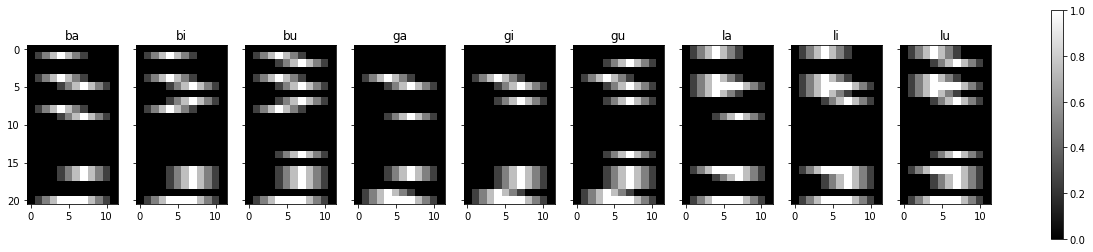

In [7]:
ncols = len(I_dict)
nrows = 1

subplot_y, subplot_x = I.shape
scale = 0.2
subplot_y, subplot_x = tuple(i * scale for i in (subplot_y, subplot_x))

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharex=True, sharey=True)

for k, ax in zip(I_dict.keys(), axes.flatten()):
    im = ax.imshow(I_dict[k], cmap="gray")
    ax.set_title(k)
    
fig.colorbar(im, ax=axes.ravel().tolist());

# Parameters

In [8]:
epoch_max = max(range(epoch_n))

vec_len = len(I_dict)
I_size = I.shape[0]
r2_size = vec_len

r1 = np.zeros(r1_size)
r2 = np.zeros(r2_size)

np.random.seed(1)
U1 = np.random.normal(loc=0, scale=0.1, size=(I_size, r1_size))
U2 = np.random.normal(loc=0, scale=0.1, size=(r1_size, r2_size))
U3 = np.random.normal(loc=0, scale=0.1, size=(r2_size, vec_len))
V1 = np.random.normal(loc=0, scale=0.1, size=(r1_size, r1_size))
V2 = np.random.normal(loc=0, scale=0.1, size=(r2_size, r2_size))

# Before Training

In [9]:
U1_hat = U1.copy()
U2_hat = U2.copy()
U3_hat = U3.copy()
V1_hat = V1.copy()
V2_hat = V2.copy()

output_test_df = apply_input(I_dict, training=False, af=act_func)

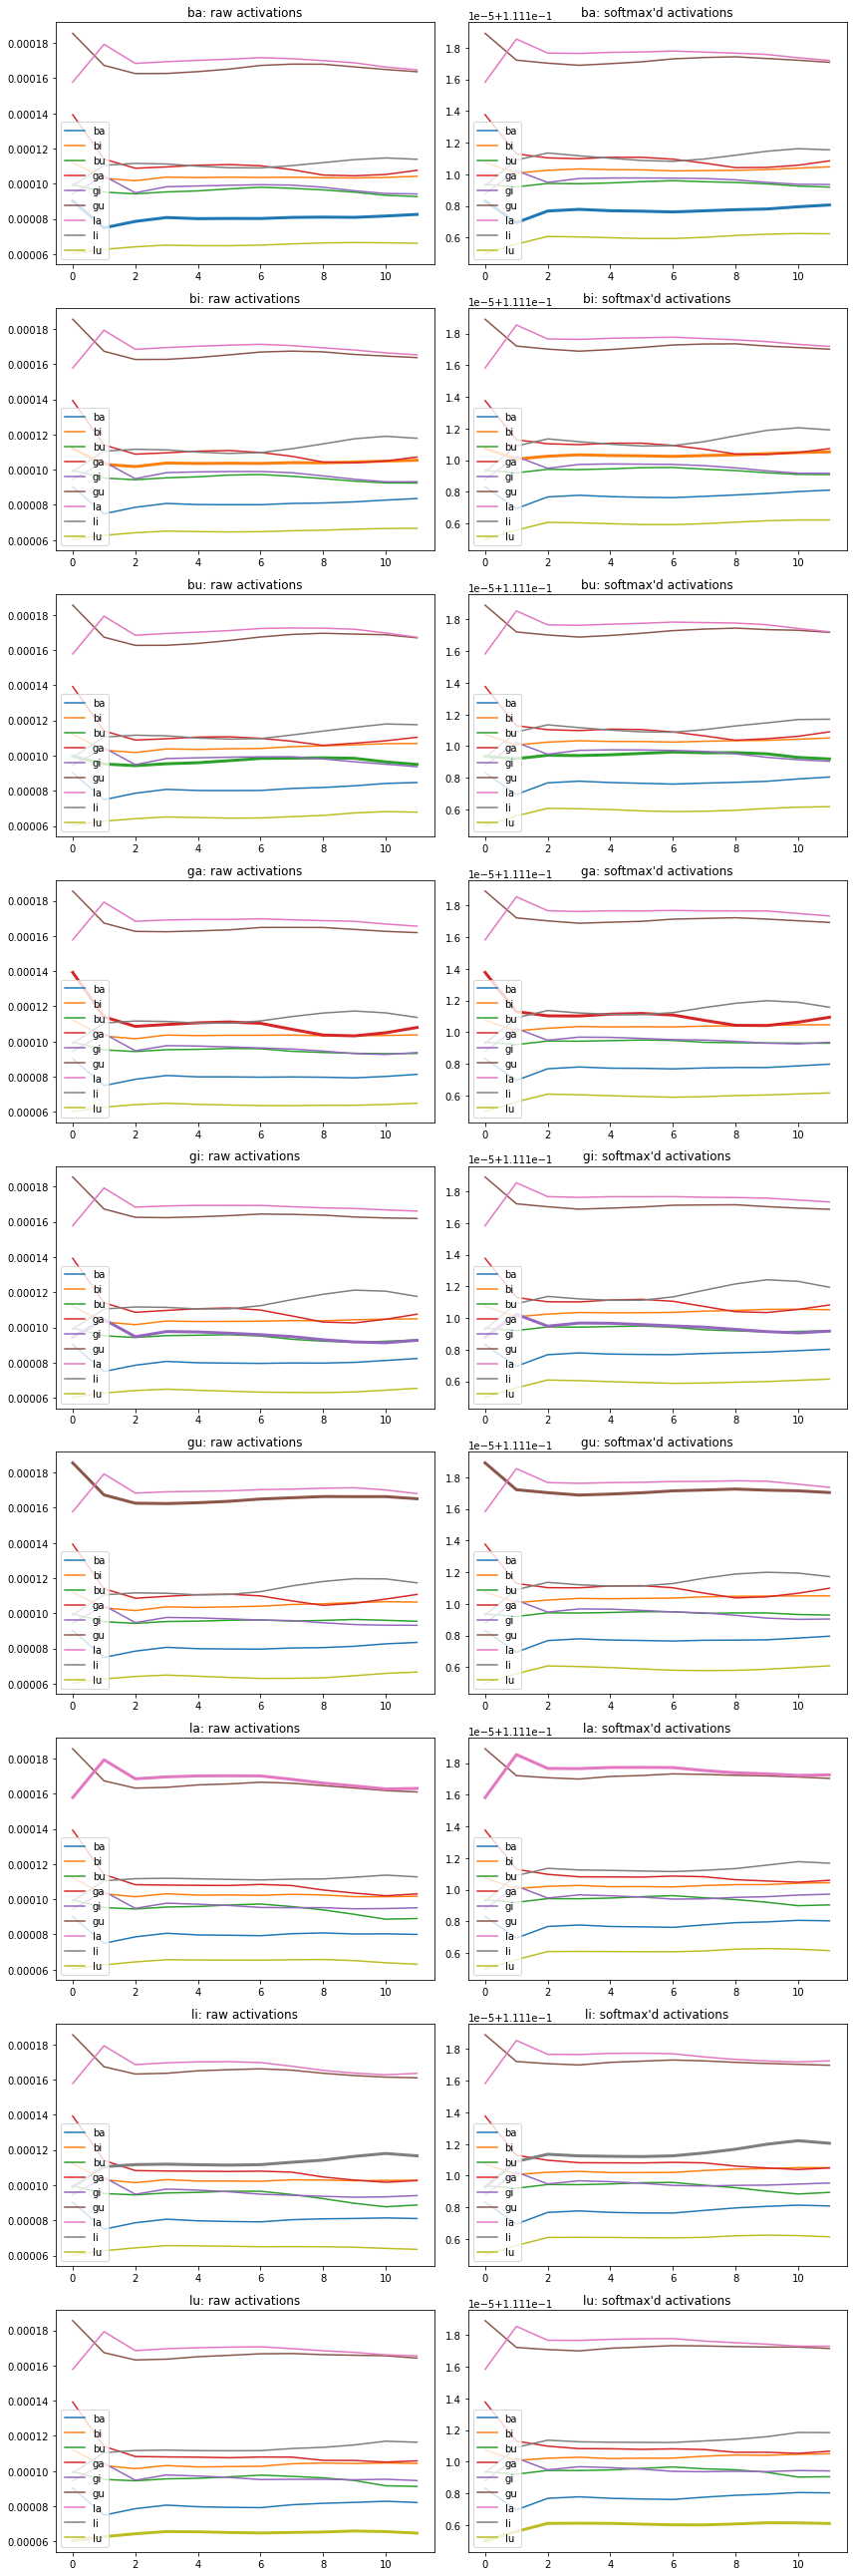

In [10]:
output_test_df["U3Tr2"] = output_test_df.apply(lambda x: x.U3_hat.T @ x.r2_hat, axis=1)

raw_vs_softmax_plots(df=output_test_df, ncols=2, nrows=9, subplot_yx=(4,6), scale=1, groupby="label", value="U3Tr2", c=softmax_c)

# Training & Testing

In [11]:
U1_hat = U1.copy()
U2_hat = U2.copy()
U3_hat = U3.copy()
V1_hat = V1.copy()
V2_hat = V2.copy()

output_train_list = []
output_test_list = []

for epoch in np.arange(epoch_n):
    output_train_i = apply_input(I_dict, training=True, af=act_func, seed=epoch)
    output_train_i["epoch"] = epoch
    if epoch % save_interval == save_interval-1:
        output_train_list.append(output_train_i)
        
        output_test_i = apply_input(I_dict, training=False, af=act_func)
        output_test_i["epoch"] = epoch
        output_test_list.append(output_test_i)

output_train_df = pd.concat(output_train_list)
output_test_df = pd.concat(output_test_list)

## Training Timecourse at Last Epoch

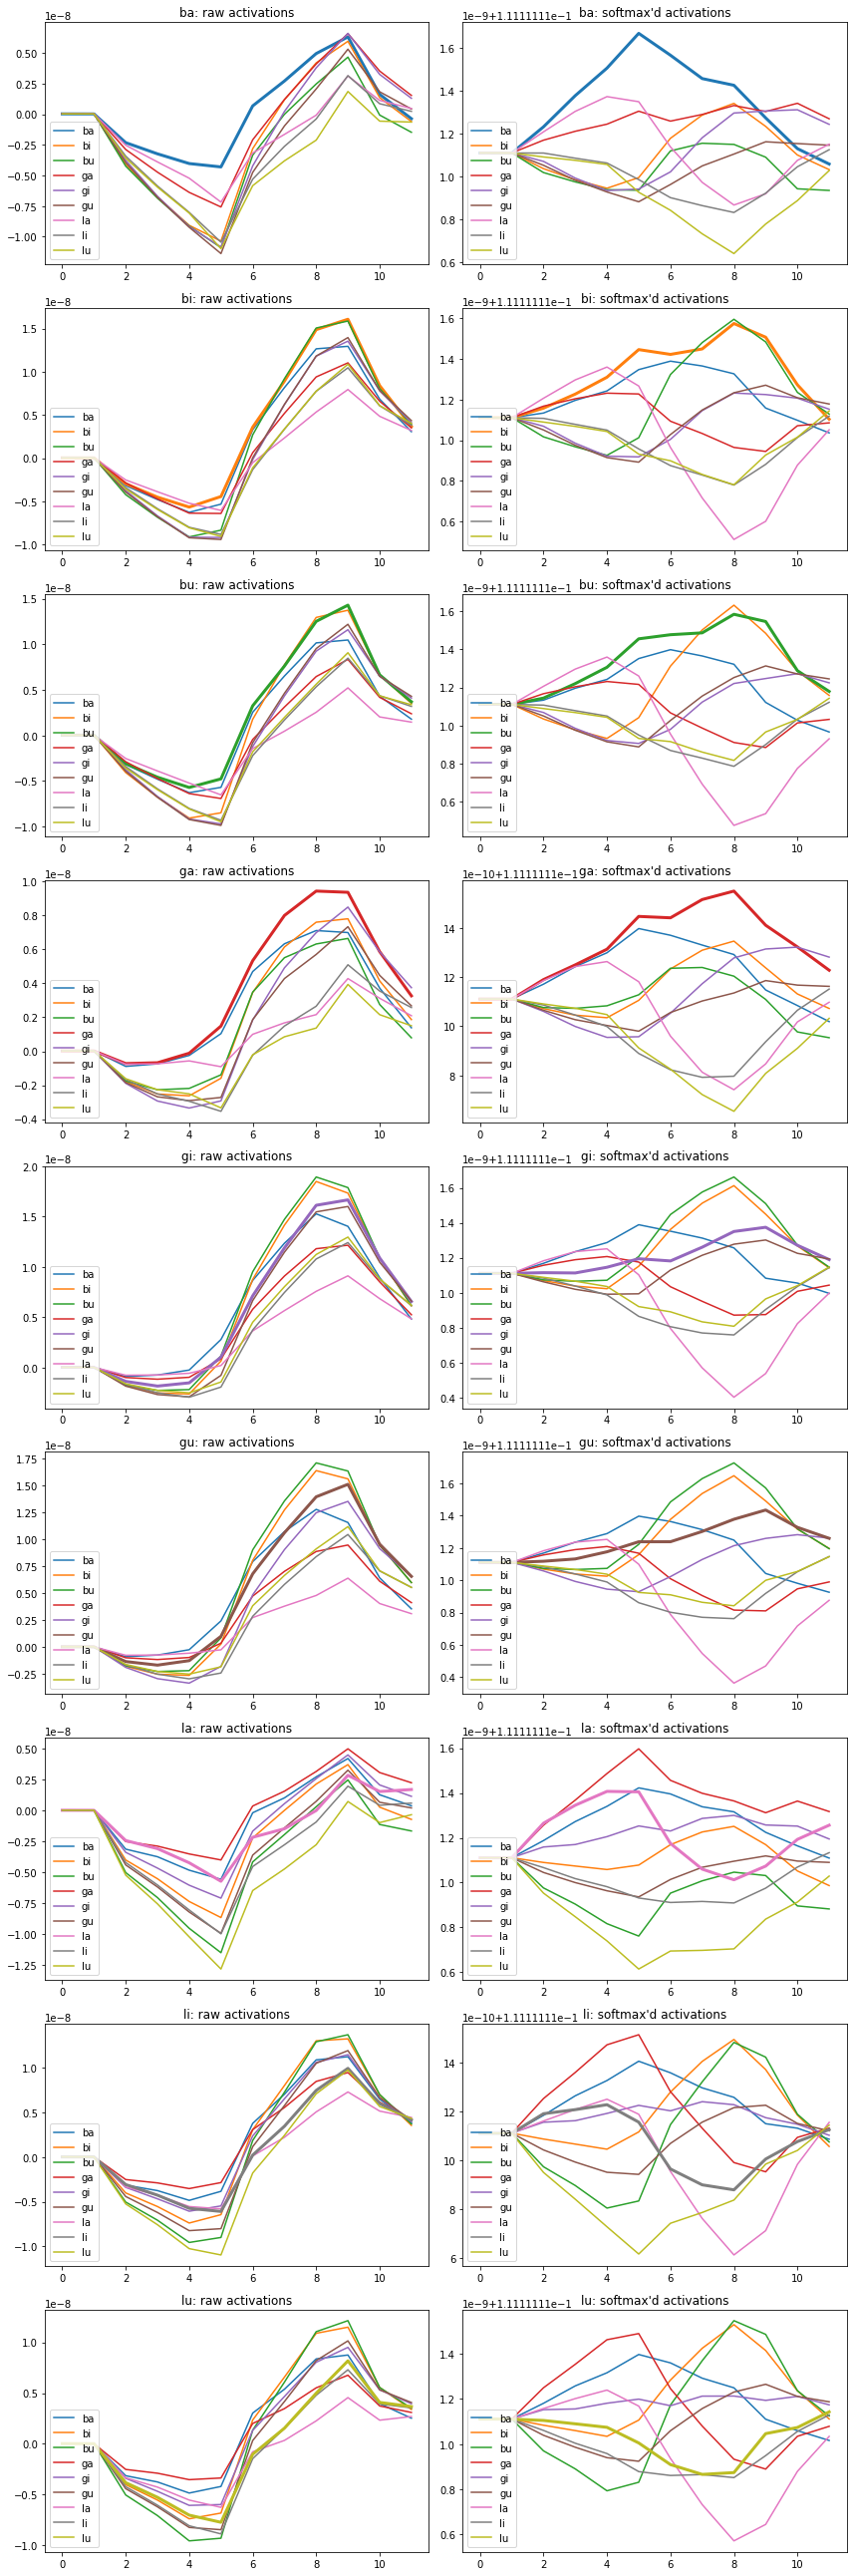

In [12]:
output_train_df["U3Tr2"] = output_train_df.apply(lambda x: x.U3_hat.T @ x.r2_hat, axis=1)

raw_vs_softmax_plots(df=output_train_df.groupby("epoch").get_group(epoch_max),
                     ncols=2, nrows=9, subplot_yx=(4,6), scale=1, groupby="label", value="U3Tr2", c=softmax_c)

## Testing Timecourse at Last Epoch

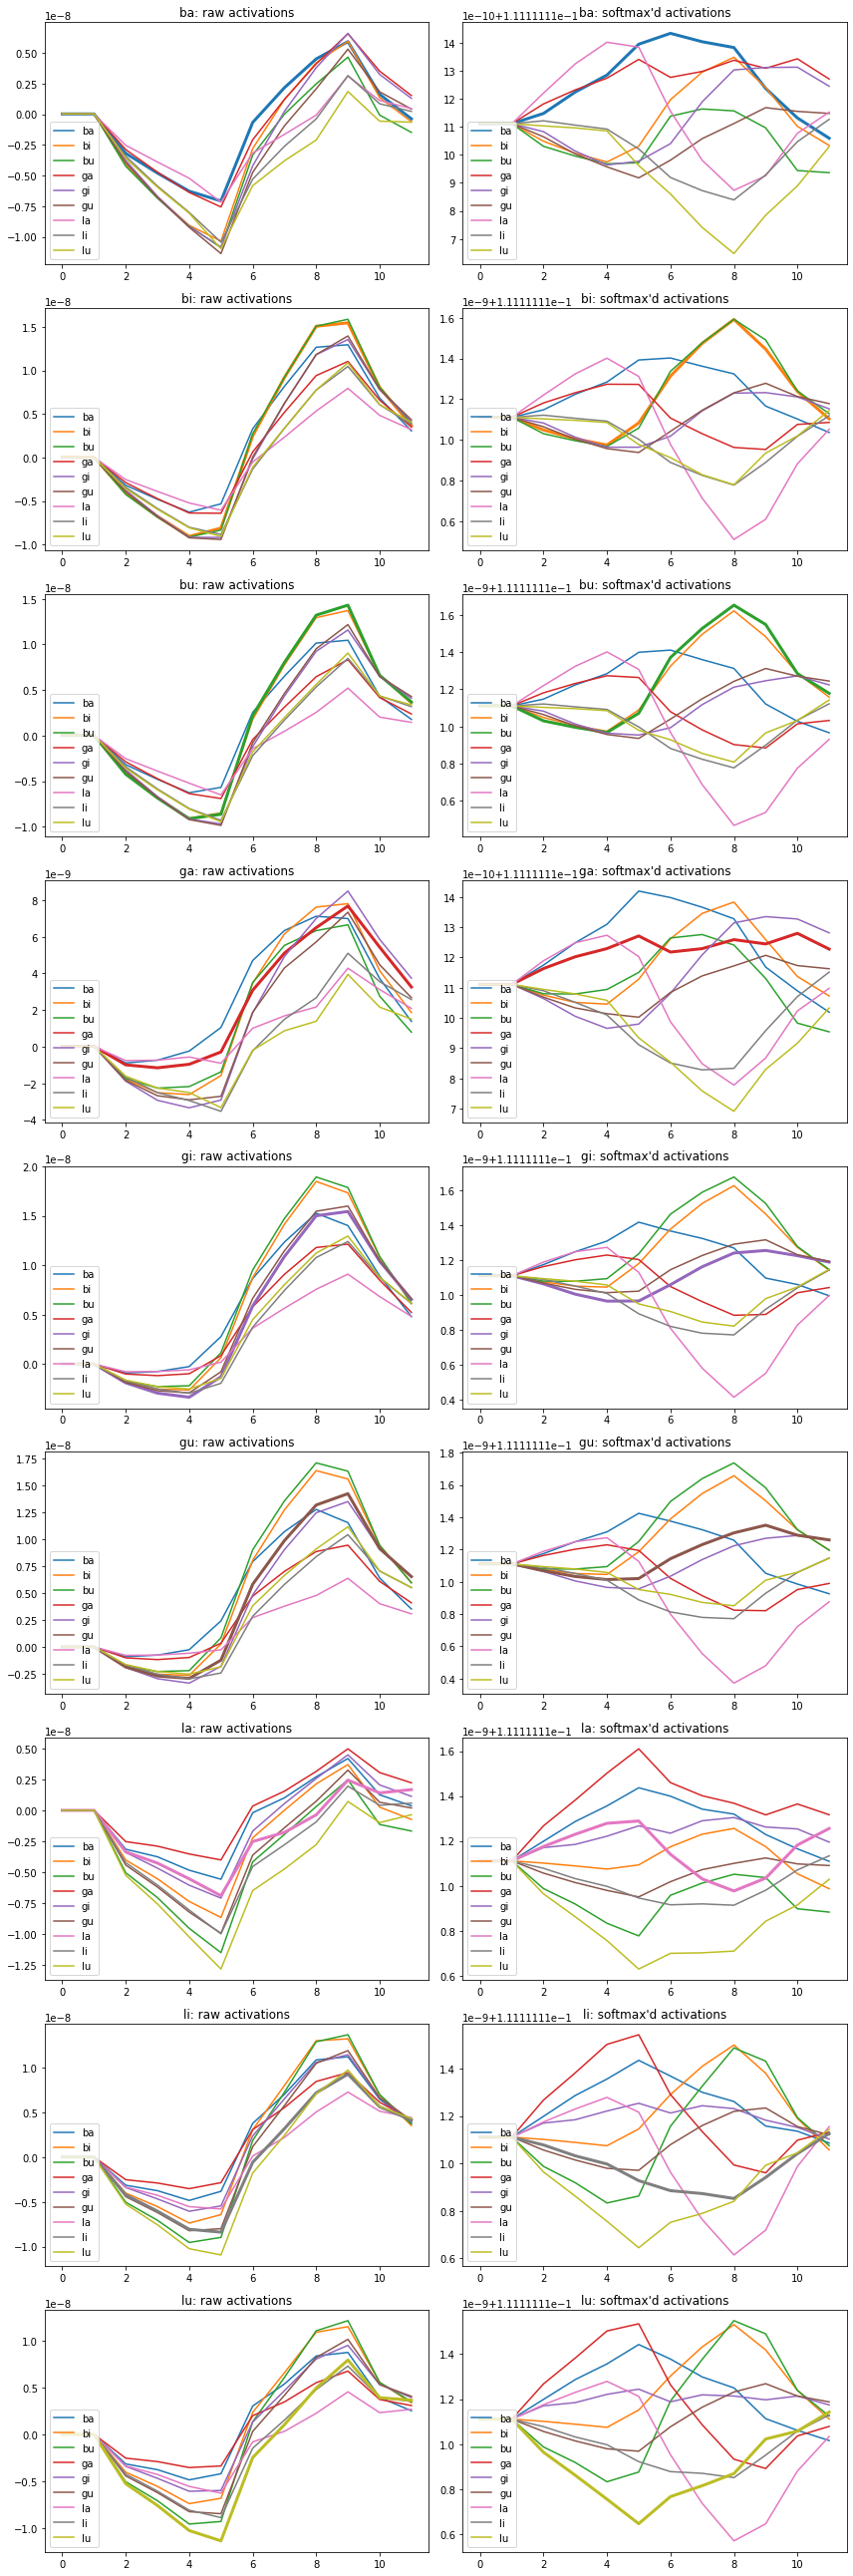

In [13]:
output_test_df["U3Tr2"] = output_test_df.apply(lambda x: x.U3_hat.T @ x.r2_hat, axis=1)

raw_vs_softmax_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
                     ncols=2, nrows=9, subplot_yx=(4,6), scale=1, groupby="label", value="U3Tr2", c=softmax_c)

# Input Reconstruction

In [14]:
ncols = len(I_dict)
nrows = 1
subplot_yx = I.shape
scale = 0.2

## Actual Inputs

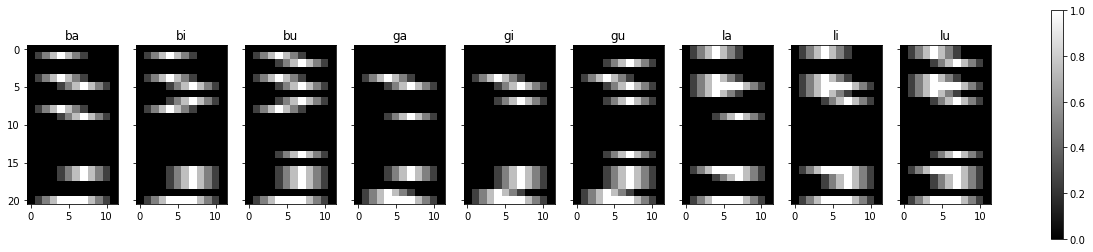

In [15]:
recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale, groupby="label", value="input")

## Reconstruction Based on r1_hat

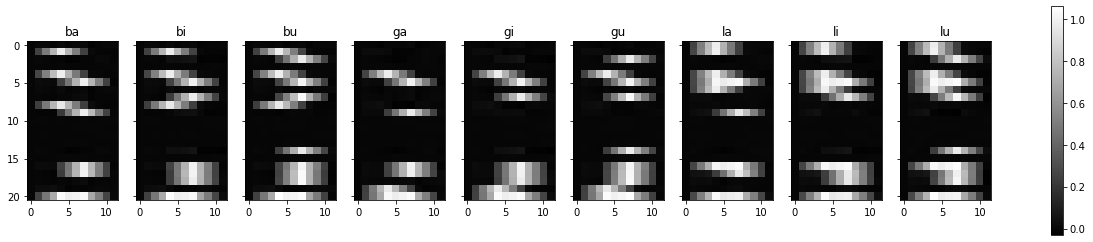

In [16]:
output_test_df["r1_hat_recon"] = output_test_df.apply(lambda x: x.U1_hat @ x.r1_hat, axis=1)

recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale, groupby="label", value="r1_hat_recon")

## Reconstruction Based on r1_bar

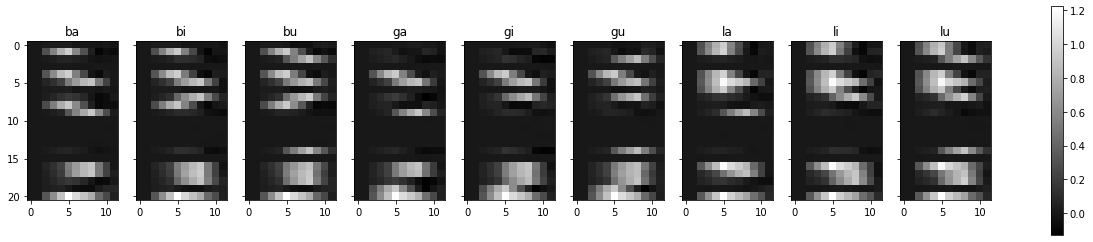

In [17]:
output_test_df["r1_bar_recon"] = output_test_df.apply(lambda x: x.U1_hat @ x.r1_bar, axis=1)

recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale, groupby="label", value="r1_bar_recon")

## Differences of Reconstruction of r1_bar and r1_hat

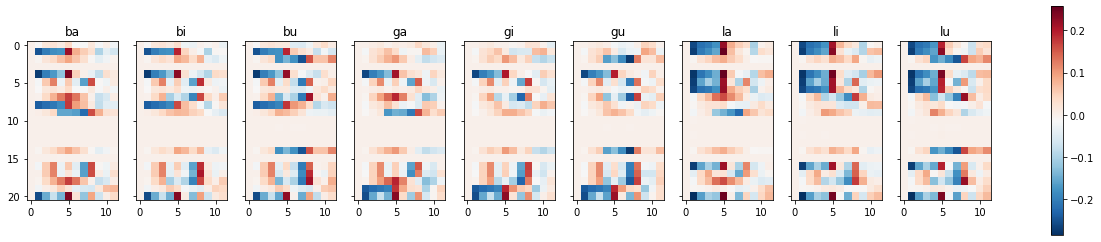

In [18]:
output_test_df["r1_recon_diff"] = output_test_df.apply(lambda x: x.r1_bar_recon - x.r1_hat_recon, axis=1)

recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale, groupby="label", value="r1_recon_diff", cmap="RdBu_r")

# Target Reconstruction

In [19]:
ncols = len(I_dict)
nrows = 1
subplot_yx = (len(I_dict), I.shape[1])
scale = 0.3

## Actual Target Vector

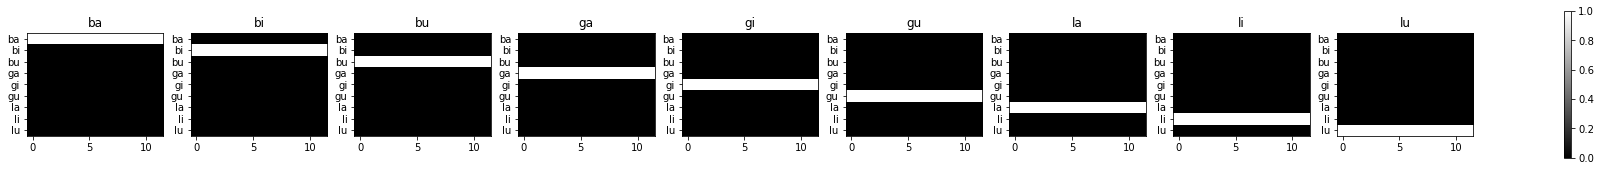

In [20]:
recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale,
            groupby="label", value="target_vec", sharey=False, y_label_list=list(I_dict.keys()))

## Softmax'd U3_hat.T @ r2_hat During Training

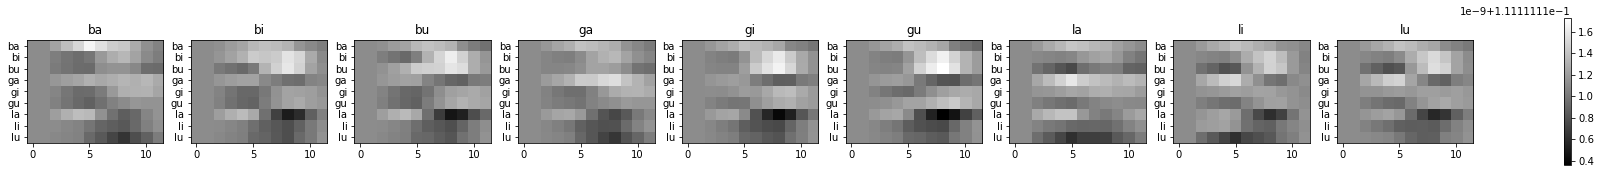

In [21]:
output_train_df["softmaxd_U3Tr2"] = output_train_df.apply(lambda x: softmax(x.U3Tr2, c=softmax_c), axis=1)

recon_plots(df=output_train_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale,
            groupby="label", value="softmaxd_U3Tr2", sharey=False, y_label_list=list(I_dict.keys()))

## Softmax'd U3_hat.T @ r2_hat During Testing

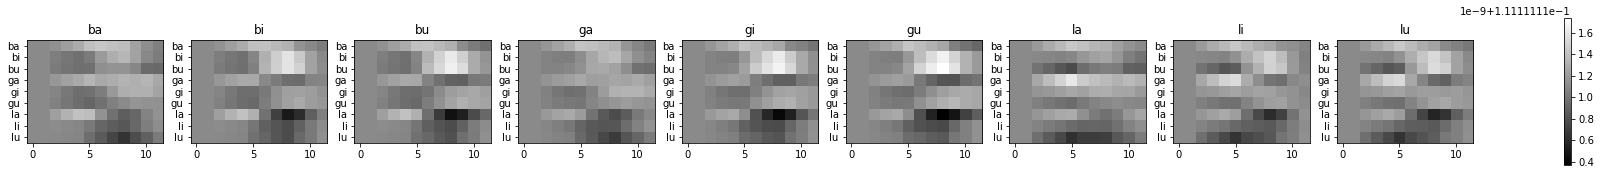

In [22]:
output_test_df["softmaxd_U3Tr2"] = output_test_df.apply(lambda x: softmax(x.U3Tr2, c=softmax_c), axis=1)

recon_plots(df=output_test_df.groupby("epoch").get_group(epoch_max),
            ncols=ncols, nrows=nrows, subplot_yx=subplot_yx, scale=scale,
            groupby="label", value="softmaxd_U3Tr2", sharey=False, y_label_list=list(I_dict.keys()))

# Accuracy

## Training

In [23]:
train_recog_df = output_train_df.groupby(["epoch", "label"]).softmaxd_U3Tr2.apply(lambda x: recog(x, mode=recog_mode, value=recog_value)).rename("recog_node").to_frame()
output_train_df = pd.merge(output_train_df, train_recog_df,
                          left_on=["epoch", "label"], right_on=["epoch", "label"],
                          how="inner", suffixes=("_old", ""))
output_train_df["label_node"] = output_train_df.apply(lambda x: list(I_dict.keys()).index(x.label), axis=1)
output_train_df["accuracy"] = output_train_df.apply(lambda x: int(x.label_node == x.recog_node), axis=1)

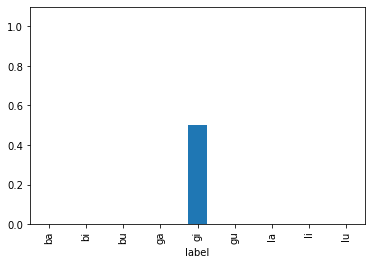

In [24]:
output_train_df.groupby("label").mean().accuracy.plot.bar(ylim=(0, 1.1));

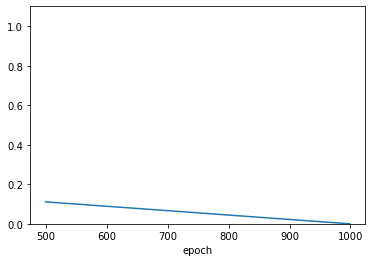

In [25]:
output_train_df.groupby("epoch").mean().accuracy.plot(ylim=(0, 1.1));

## Testing

In [26]:
test_recog_df = output_test_df.groupby(["epoch", "label"]).softmaxd_U3Tr2.apply(lambda x: recog(x, mode=recog_mode, value=recog_value)).rename("recog_node").to_frame()
output_test_df = pd.merge(output_test_df, test_recog_df,
                          left_on=["epoch", "label"], right_on=["epoch", "label"],
                          how="inner", suffixes=("_old", ""))
output_test_df["label_node"] = output_test_df.apply(lambda x: list(I_dict.keys()).index(x.label), axis=1)
output_test_df["accuracy"] = output_test_df.apply(lambda x: int(x.label_node == x.recog_node), axis=1)

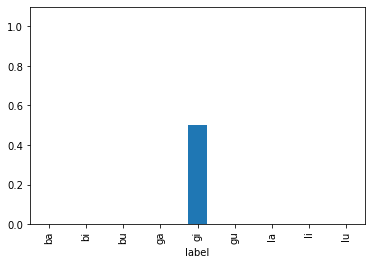

In [27]:
output_test_df.groupby("label").mean().accuracy.plot.bar(ylim=(0, 1.1));

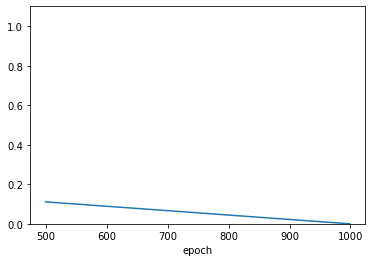

In [28]:
output_test_df.groupby("epoch").mean().accuracy.plot(ylim=(0, 1.1));

# Loss Function Error Terms

## Training

In [29]:
output_train_df["e10"] = 1/s10 * output_train_df.apply(lambda x: x.input - f(x.U1_hat @ x.r1_hat, af=act_func), axis=1).apply(lambda x: x.T @ x)
output_train_df["e11"] = 1/s11 * output_train_df.apply(lambda x: x.r1_hat - x.r1_bar, axis=1).apply(lambda x: x.T @ x)
output_train_df["e21"] = 1/s21 * output_train_df.apply(lambda x: x.r1_hat - f(x.U2_hat @ x.r2_hat, af=act_func), axis=1).apply(lambda x: x.T @ x)
output_train_df["e22"] = 1/s22 * output_train_df.apply(lambda x: x.r2_hat - x.r2_bar, axis=1).apply(lambda x: x.T @ x)
output_train_df["e32"] = 1/s32 * output_train_df.apply(lambda x: -np.sum(x.target_vec * np.log(softmax(x.U3_hat.T @ x.r2_hat))), axis=1)

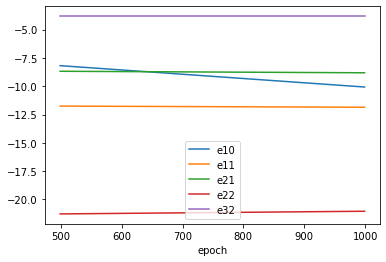

In [30]:
output_train_df.groupby(["epoch"]).mean()[["e10", "e11", "e21", "e22", "e32"]].applymap(lambda x: np.log(x)).plot();

## Testing

In [31]:
output_test_df["e10"] = 1/s10 * output_test_df.apply(lambda x: x.input - f(x.U1_hat @ x.r1_hat, af=act_func), axis=1).apply(lambda x: x.T @ x)
output_test_df["e11"] = 1/s11 * output_test_df.apply(lambda x: x.r1_hat - x.r1_bar, axis=1).apply(lambda x: x.T @ x)
output_test_df["e21"] = 1/s21 * output_test_df.apply(lambda x: x.r1_hat - f(x.U2_hat @ x.r2_hat, af=act_func), axis=1).apply(lambda x: x.T @ x)
output_test_df["e22"] = 1/s22 * output_test_df.apply(lambda x: x.r2_hat - x.r2_bar, axis=1).apply(lambda x: x.T @ x)
output_test_df["e32"] = 1/s32 * output_test_df.apply(lambda x: -np.sum(x.target_vec * np.log(softmax(x.U3_hat.T @ x.r2_hat))), axis=1)

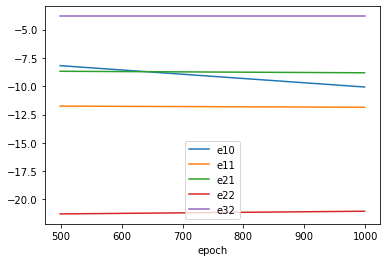

In [32]:
output_test_df.groupby(["epoch"]).mean()[["e10", "e11", "e21", "e22", "e32"]].applymap(lambda x: np.log(x)).plot();

# Weights

In [33]:
timesteps_per_epoch = sum(output_train_df.epoch == epoch_max)

ALL_WEIGHTS_DF = output_train_df.loc[output_train_df.index % timesteps_per_epoch == timesteps_per_epoch - 1]
ALL_WEIGHTS_DF = ALL_WEIGHTS_DF.reset_index(drop=True)

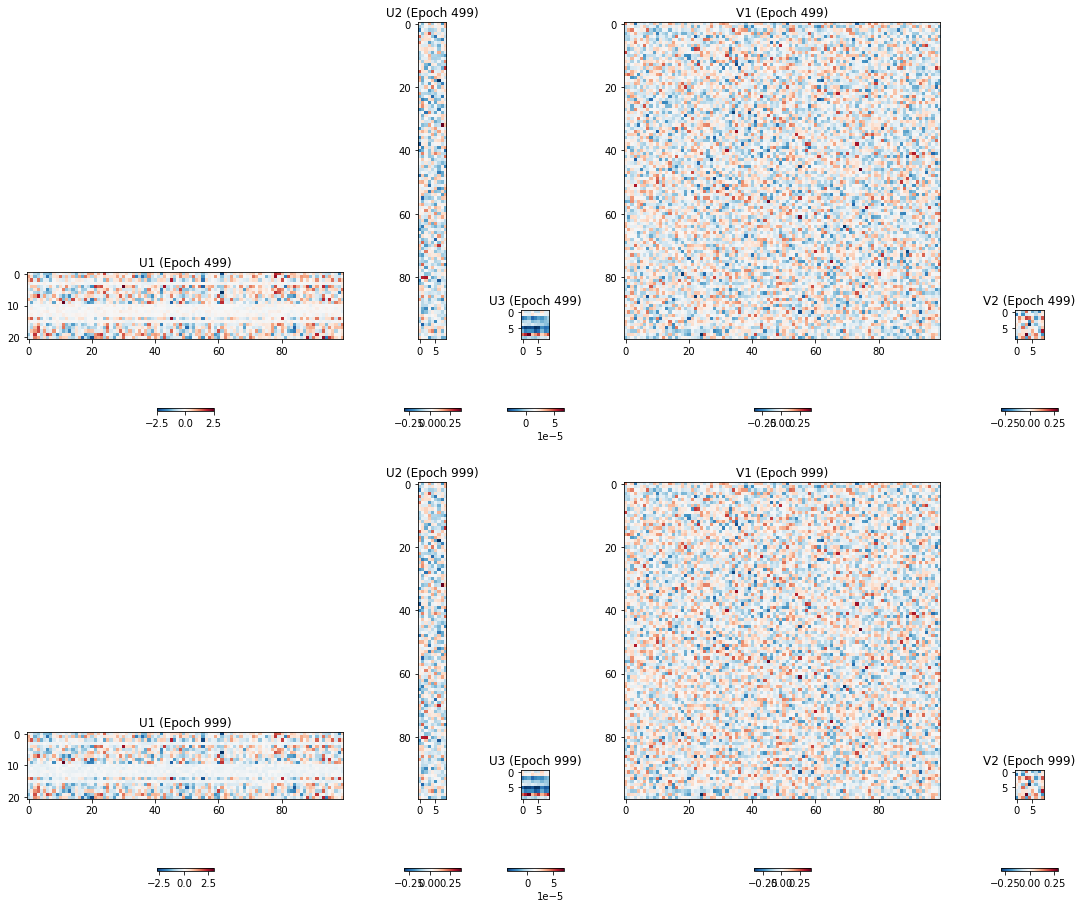

In [34]:
# subplots settings
ncols = 5
nrows = len(ALL_WEIGHTS_DF.index)

weight_shape_list = [U1.shape, U2.shape, U3.shape, V1.shape, V2.shape]

subplot_x = sum([x[1] for x in weight_shape_list]) / 15
subplot_y = max([x[0] for x in weight_shape_list]) / 15
min_x = min([x[1] for x in weight_shape_list]) 

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x, subplot_y*nrows),
                         gridspec_kw={'width_ratios': [x[1] for x in weight_shape_list]})

# fig, axes = plt.subplots(nrows, ncols, figsize=(20, 4*nrows))

cmap = "RdBu_r"

for x in range(axes.shape[0]):
    im_0 = axes[x, 0].imshow(ALL_WEIGHTS_DF.U1_hat[x], cmap=cmap)
    im_1 = axes[x, 1].imshow(ALL_WEIGHTS_DF.U2_hat[x], cmap=cmap)
    im_2 = axes[x, 2].imshow(ALL_WEIGHTS_DF.U3_hat[x], cmap=cmap)
    im_3 = axes[x, 3].imshow(ALL_WEIGHTS_DF.V1_hat[x], cmap=cmap)
    im_4 = axes[x, 4].imshow(ALL_WEIGHTS_DF.V2_hat[x], cmap=cmap)
    
    axes[x, 0].set_title("U1 (Epoch {})".format(ALL_WEIGHTS_DF.epoch[x]))
    axes[x, 1].set_title("U2 (Epoch {})".format(ALL_WEIGHTS_DF.epoch[x]))
    axes[x, 2].set_title("U3 (Epoch {})".format(ALL_WEIGHTS_DF.epoch[x]))
    axes[x, 3].set_title("V1 (Epoch {})".format(ALL_WEIGHTS_DF.epoch[x]))
    axes[x, 4].set_title("V2 (Epoch {})".format(ALL_WEIGHTS_DF.epoch[x]))
    
    fig.colorbar(im_0, ax=axes[x, 0], orientation="horizontal", shrink=2*min_x/U1.shape[1]);
    fig.colorbar(im_1, ax=axes[x, 1], orientation="horizontal", shrink=2*min_x/U2.shape[1]);
    fig.colorbar(im_2, ax=axes[x, 2], orientation="horizontal", shrink=2*min_x/U3.shape[1]);
    fig.colorbar(im_3, ax=axes[x, 3], orientation="horizontal", shrink=2*min_x/V1.shape[1]);
    fig.colorbar(im_4, ax=axes[x, 4], orientation="horizontal", shrink=2*min_x/V2.shape[1]);

plt.tight_layout()

# Output

In [35]:
output_df = pd.concat([output_test_df, output_train_df])
output_pkl = "{}_{}_{}_results.pkl".format(timestamp, param_id, re.sub("\.ipynb$", "", ipynb))
output_df.to_pickle(os.path.join(out_dir, output_pkl))